###### Inicialização

In [ ]:
!pip install meteostat yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta
from IPython.display import Markdown
from itertools import product

from math import log
from scipy import stats
from scipy.optimize import minimize
import statsmodels.api as sm
from statsmodels.graphics import tsaplots as tsa

from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
 
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (22,6)

from meteostat import Point, Daily

from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

import seaborn as sns
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

In [ ]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["figure.figsize"] = (22,6)

In [ ]:
def resultado_adf(resultado, alpha = .05):
  adf, pvalue, usedlag, nobs, critical = resultado[0:5]
  
  display(Markdown('Statistics=%.3f, p-valor=%.8f' % (adf, pvalue)))
  # interpretando resultados
  if pvalue > alpha:
      display(Markdown("**A série não é estacionária (falhamos em rejeitar H0)**"))
  else:
      display(Markdown('**A série é estacionária (rejeitamos H0)**'))

In [ ]:
def resultado_white(resultado, alpha = .05):
  lm, p_value, fvalue, fp_value = resultado[0:5]
  
  display(Markdown('Statistics=%.3f, p-valor=%.8f' % (lm, p_value)))
  # interpretando resultados
  if p_value > alpha:
      display(Markdown("**A série não é heterocedástica (falhamos em rejeitar H0)**"))
  else:
      display(Markdown('**A série é heterocedástica (rejeitamos H0)**'))

In [ ]:
mape = lambda y_true, y_pred: np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Captura dos dados de temperatura

In [ ]:
start = datetime(2010, 1, 1)
end = datetime(2022, 12, 31)

location = Point(-11.0056387, -37.2432436) #Aracaju

aracaju = Daily(location, start, end)
serie_aracaju = aracaju.fetch()

serie_aracaju.tavg.fillna(serie_aracaju.tavg.mean(),inplace=True)

In [ ]:
def visualizaModelo(series, model, n_steps, teste=None, plot_intervals=False, scale=1.96):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies
    """

    data = series.copy().to_frame()
    data.columns = ["actual"]
    data["model"] = model.fittedvalues[model.fittedvalues.index >= data.index[0]]

    forecast = model.predict(start=data.index[-1], end=data.index[-1] + timedelta(days=n_steps))
    forecast = data.model.append(forecast)

    mae = metrics.mean_absolute_error(series, data["model"])
    deviation = np.std(series - data["model"])
    lower_bond = forecast - (mae + scale * deviation)
    upper_bond = forecast + (mae + scale * deviation)

    plt.figure(figsize=(20, 10))
    plt.plot(forecast, label="Model")
    plt.plot(data.actual, label="Real Treino")
    if teste is not None:
      plt.plot(teste, label="Real Teste")
    error = mape(series.values, data["model"])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))

    if plot_intervals:
        plt.plot(upper_bond, "r--", alpha=0.5, label="Up/Low confidence")
        plt.plot(lower_bond, "r--", alpha=0.5)
        plt.fill_between(
            x=upper_bond.index,
            y1=upper_bond,
            y2=lower_bond,
            alpha=0.2,
            color="grey",
        )

    plt.vlines(
        series.iloc[-1:].index[0],
        ymin=min(lower_bond),
        ymax=max(upper_bond),
        linestyles="dashed",
    )

    plt.axvspan(series.iloc[-1:].index[0], forecast.index[-1], alpha=0.3, color="lightgrey")
    plt.grid(True)
    plt.axis("tight")
    plt.legend(loc="best", fontsize=13);

In [ ]:
def auto_ARIMA(experimentos, dados):
  resultados = []
  
  for experimento in tqdm(experimentos):
    try: 
      modelo = sm.tsa.arima.ARIMA(dados, order=experimento).fit()
    except:
      continue
          
    mae = metrics.mean_absolute_error(dados, modelo.fittedvalues)
    mape_erro = mape(dados, modelo.fittedvalues)
    resultados.append([experimento, modelo.aic, mae, mape_erro, modelo])

  resultados_df = pd.DataFrame(resultados)
  resultados_df.columns = ['(p, d, q)', 'AIC', 'MAE', 'MAPE', 'modelo']
  
  resultados = resultados_df.sort_values(by='MAE', ascending=True).reset_index(drop=True) #ordena pelo AIC
  
  return resultados

In [ ]:
def predicao_por_rolagem(treino, teste, order, ts=1):
    history = treino.copy()
    model = sm.tsa.arima.ARIMA(history, order= order).fit()
    predictions = []
    results = {}
    yhat = model.forecast()[0]

    predictions.append(yhat)
    history.loc[teste.index[0]] = teste[0]
    for i in tqdm(range(1, len(teste))):
        model = sm.tsa.arima.ARIMA(history, order= order).fit()
        yhat = model.forecast(steps=ts)[0]
        predictions.append(yhat)
        history.loc[teste.index[i]] = teste[i]

    return pd.Series(predictions, index=teste.index)

In [ ]:
def predicao_por_rolagem_h(treino, teste, order, ts=1):
    history = treino.copy()
    model = sm.tsa.arima.ARIMA(history, order= order).fit()
    results = {}
    predictions = pd.DataFrame(model.forecast(steps=ts).values.reshape(1,-1))

    history.loc[teste.index[0]] = teste[0]
    for i in tqdm(range(1, len(teste))):
        model = sm.tsa.arima.ARIMA(history, order= order).fit()
        predictions.loc[i] = model.forecast(steps=ts).values.reshape(1,-1)[0]
        history.loc[teste.index[i]] = teste[i]

    return predictions

# Análise de Séries temporais (Sessão 16)
---
Modelando Séries (parte 7)

## Decompondo e Recompondo a Série



### Decompondo por Filtragem:
Resgatando da sessão 7:

In [ ]:
d2 = 365
q2 = d2 // 2
sa__ = serie_aracaju.tavg.to_frame()
sa__.columns = ["X"]

for i in range(q2):
  sa__[f"X_lag{i+1}"] = sa__["X"].shift(-(i+1-q2)) if i != (q2-1) else sa__["X"].shift(-(i+1-q2))/2
  sa__[f"X_lead{i+1}"] = sa__["X"].shift((i+1-q2)) if i != (q2-1) else sa__["X"].shift((i+1-q2))/2

sa__[f"mm{d2}"] = sa__.sum(axis=1) / d2
sa__ = sa__.iloc[q2:]
sa__ = sa__.iloc[:-q2]

In [ ]:
sa__["Dia"] = sa__.index.day_of_year
sa__["Semana"] = sa__.index.isocalendar().week
sa__["Mês"] = sa__.index.month

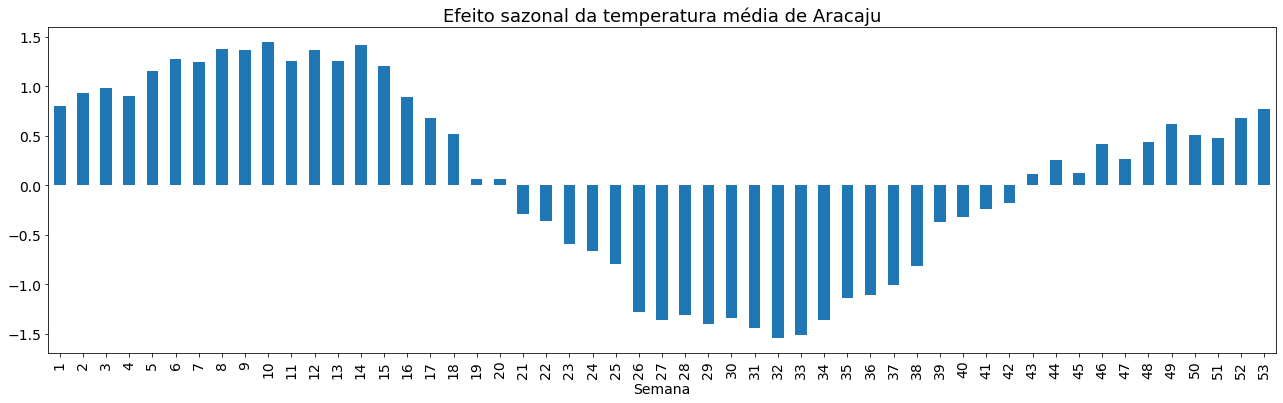

In [ ]:
sazonal_aracaju = sa__.groupby("Semana")[["X", f"mm{d2}"]].mean()
sazonal_aracaju["efeito"] = (sazonal_aracaju["X"] - sazonal_aracaju[f"mm{d2}"])

_ = sazonal_aracaju["efeito"].plot(kind='bar', title = "Efeito sazonal da temperatura média de Aracaju")

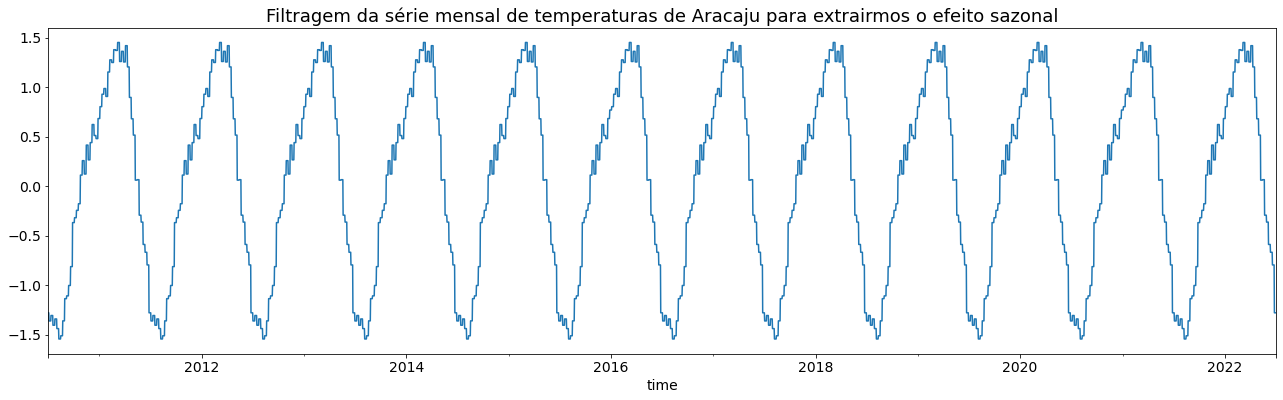

In [ ]:
sa__["efeito_sazonal"] = sa__["Semana"].map(sazonal_aracaju["efeito"]) #Aplicando o efeito sazonal estimado em toda a série 

_ = sa__["efeito_sazonal"].plot(title="Filtragem da série mensal de temperaturas de Aracaju para extrairmos o efeito sazonal")

In [ ]:
sa__["resíduo"] = sa__["X"] - (sa__[f"mm{d2}"] + sa__["efeito_sazonal"])

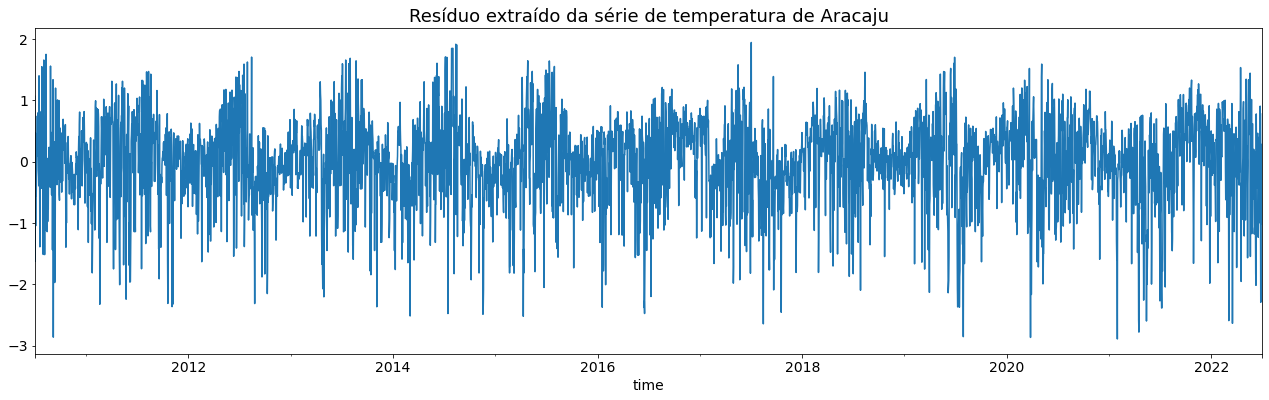

In [ ]:
_ = sa__["resíduo"].plot(title= "Resíduo extraído da série de temperatura de Aracaju")

### Modelando

In [ ]:
resultado_adf(sm.tsa.adfuller(sa__["resíduo"]), alpha = .05)

Statistics=-14.391, p-valor=0.00000000

**A série é estacionária (rejeitamos H0)**

In [ ]:
split = int(len(sa__["resíduo"]) * 80 / 100) #encontrando o ponto de separação de 80% para treino e 20% para teste
treino, teste = sa__["resíduo"][:split], sa__["resíduo"][split:]

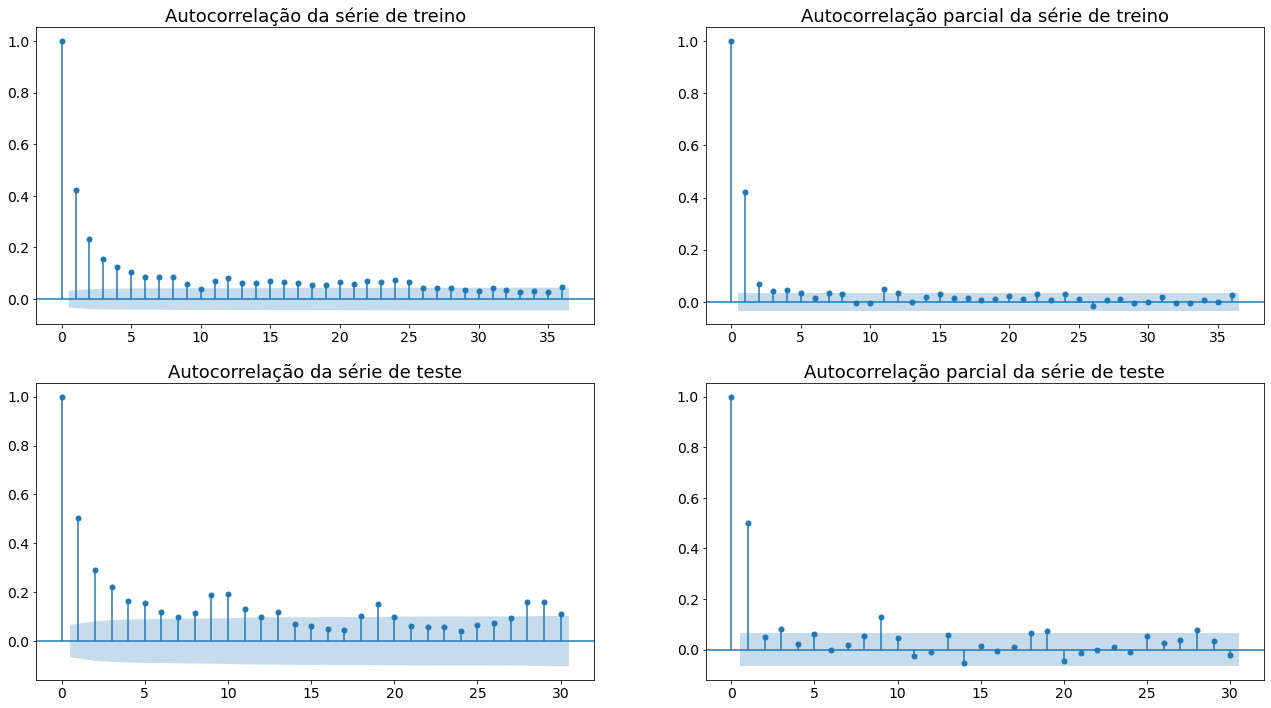

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(22,12))
tsa.plot_acf(treino, ax = axs[0,0], title="Autocorrelação da série de treino")
tsa.plot_pacf(treino, ax = axs[0,1], title="Autocorrelação parcial da série de treino")
tsa.plot_acf(teste, ax = axs[1,0], title="Autocorrelação da série de teste")
_ = tsa.plot_pacf(teste, ax = axs[1,1], title="Autocorrelação parcial da série de teste")

In [ ]:
ps = [1]
ds = [0]
qs = [1,2,9,10]

parameters = product(ps, ds, qs) # cria uma combinação de todos os parâmetros
parameters_list = list(parameters)

In [ ]:
result_df = auto_ARIMA(parameters_list, treino)
result_df

  0%|          | 0/4 [00:00<?, ?it/s]

,"(p, d, q)",AIC,MAE,MAPE,modelo
0,"(1, 0, 10)",6663.656695,0.464653,728.672285,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,"(1, 0, 9)",6662.076365,0.464770,715.598027,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,"(1, 0, 2)",6672.911394,0.466710,752.122491,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
3,"(1, 0, 1)",6682.416054,0.467699,735.156718,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [ ]:
modelo_autoarima = result_df.modelo.iloc[0]

In [ ]:
treino.index.max(), teste.index.min()

(Timestamp('2020-02-06 00:00:00', freq='D'),
 Timestamp('2020-02-07 00:00:00', freq='D'))

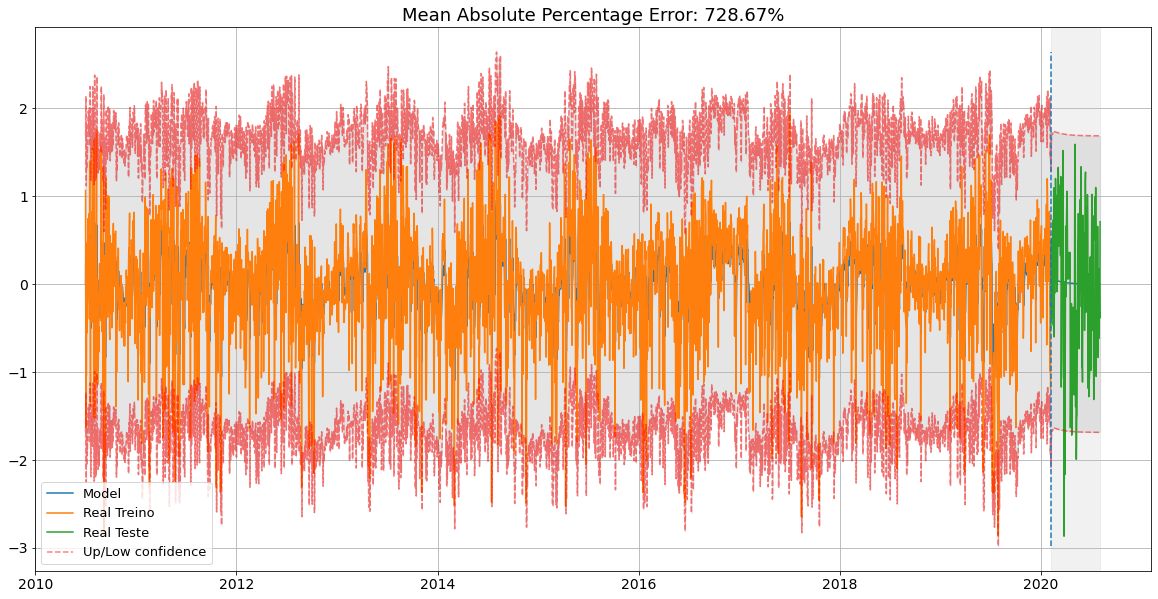

In [ ]:
visualizaModelo(treino, modelo_autoarima, n_steps=180, teste=teste[:180], plot_intervals=True)

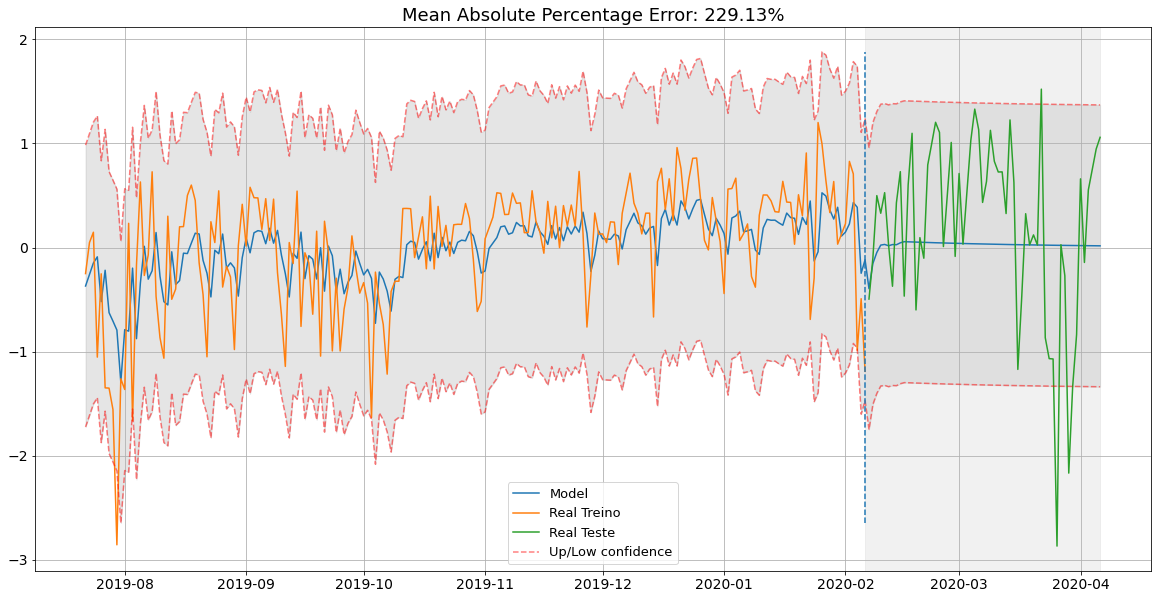

In [ ]:
visualizaModelo(treino[-200:], modelo_autoarima, 
                n_steps=60, teste=teste[:60], plot_intervals=True)

Em siguações como essa, aplicamos a previsão por rolagem

In [ ]:
ordem = result_df["(p, d, q)"].iloc[0]
resultado = predicao_por_rolagem(treino.iloc[-365:], teste, ordem)

  0%|          | 0/876 [00:00<?, ?it/s]

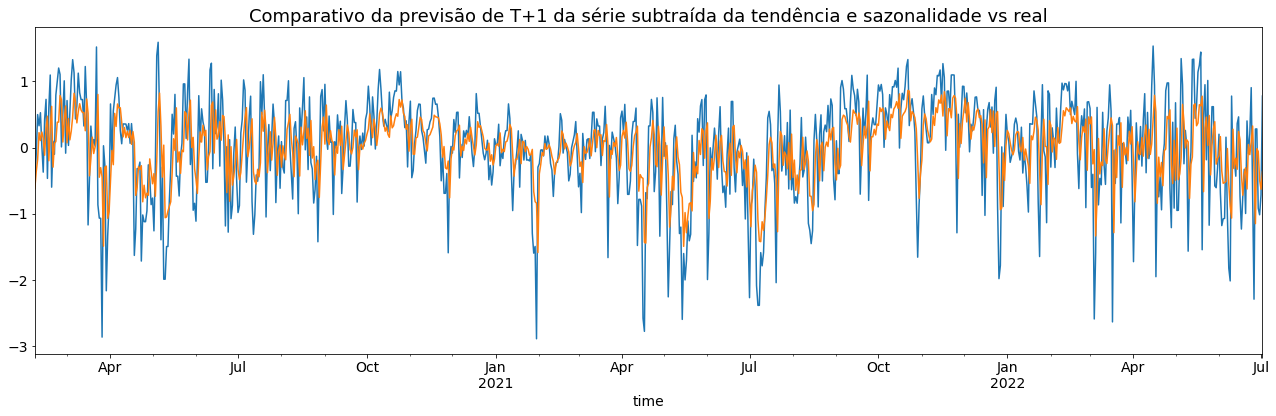

In [ ]:
ax = teste.plot(title = "Comparativo da previsão de T+1 da série subtraída da tendência e sazonalidade vs real")
_ = resultado.plot(ax=ax)

### Recompondo

In [ ]:
T = sa__[f"mm{d2}"]
T = T[(T.index >= teste.index[0]) & (T.index <= teste.index[-1])]
S = sa__["efeito_sazonal"]
S = S[(S.index >= teste.index[0]) & (S.index <= teste.index[-1])]

In [ ]:
X = serie_aracaju.tavg[(serie_aracaju.tavg.index >= teste.index[0]) & (serie_aracaju.tavg.index <= teste.index[-1])]

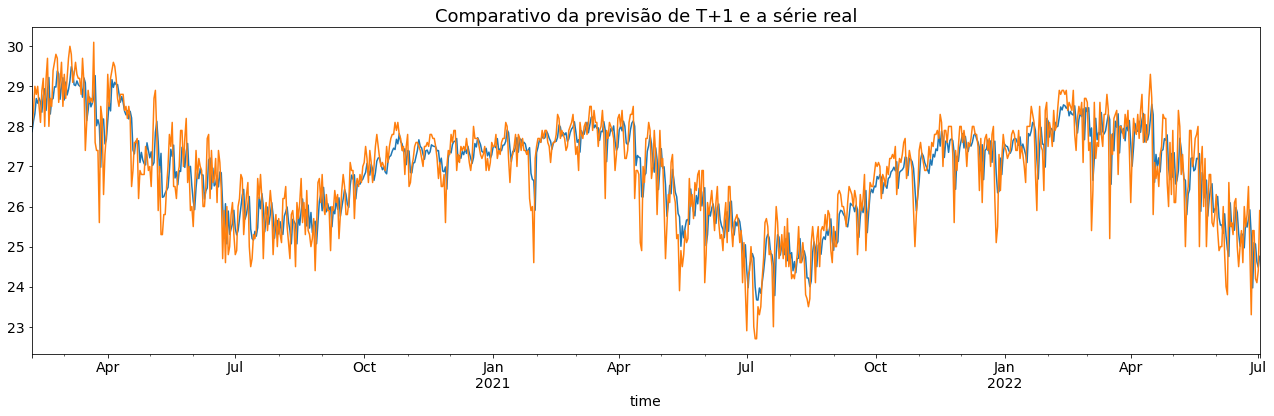

In [ ]:
ax = (resultado + T + S).plot(title = "Comparativo da previsão de T+1 e a série real")
_ = X.plot(ax=ax)

## Horizonte de predição

**Expoente de Lyapunov**

O expoente de Lyapunov é uma medida de dependência sensível das condições iniciais, ou seja, a rapidez com que dois estados próximos divergem.

Considere dois pontos na série temporal, $t_i$ e $t_j$, cujos valores são muito próximos. Isso significa que o sistema atingiu quase o mesmo estado na i-ésima e j-ésima iteração. Agora considere as duas sequências $t_i, t_{i+1}, t_{i+2}, … $e $t_j, t_{j+1}, t_{j+2}, …$ Queremos saber como essas duas sequências divergem uma da outra.

Para isso, considere a distância entre as duas sequências após $k$ passos: $d_k = | t_{i+k} – t_{j+k} |$. Se o sistema for caótico, $d(k)$ aumentará inicialmente exponencialmente com $k$. Para isso, pode-se plotar $ln(d_k)$ vs $k$ e aplicar um ajuste linear. A inclinação será uma estimativa para o expoente de Lyapunov.

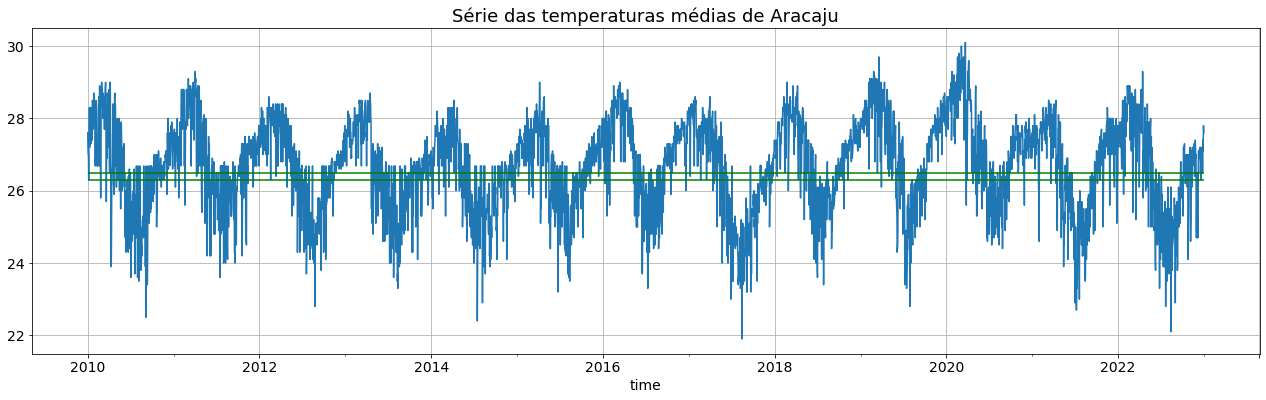

In [ ]:
ax = serie_aracaju.tavg.plot(title="Série das temperaturas médias de Aracaju")
ax.hlines(26.5, serie_aracaju.index.min(), serie_aracaju.index.max(), colors="g")
ax.hlines(26.3, serie_aracaju.index.min(), serie_aracaju.index.max(), colors="g")
ax.grid(True)
_ = ax.axis("tight")

(Como o sistema é limitado, os dois estados próximos não irão divergir indefinidamente. Sua divergência exponencial irá parar após algum comprimento. Devemos ajustar a linha reta apenas dentro desta região.)
Agora, isso foi para um único par de estados iniciais. O expoente de Lyapunov é uma média desse expoente de divergência sobre todos os pares iniciais próximos. Portanto, para isso, defina $d_k$, onde é a média de todos os pares iniciais $t_i, t_j$, de modo que a distância inicial $d_0 = | t_i – t_j |$ é menor do que um pequeno valor fixo. O código deve encontrar todos esses pares iniciais, calcula $d_k$, plota-o contra $k$, e a inclinação da parte linear inicial nos dá o expoente de Lyapunov.

- Sé $\lambda < 0$, então o sistema é convergente
- Sé $\lambda = 0$, então o sistema é conservativo
- Sé $\lambda > 0$, então o sistema é caótico

In [ ]:
#adaptação de: https://blog.abhranil.net/2014/07/22/calculating-the-lyapunov-exponent-of-a-time-series-with-python-code/
def lyapunov_exponent(series, threshold=.1):
    
  def d(series,i,j):
    return abs(series[i]-series[j])

  N=len(series)
  eps=threshold
  dlist=[[] for i in range(N)]
  n=0 #number of nearby pairs found
  for i in range(N):
      for j in range(i+1,N):
          if d(series,i,j) < eps:
              n += 1
              for k in range(min(N-i,N-j)):
                  dlist[k].append(np.log(d(series,i+k,j+k) + 1e-323))

  evaluate = []
  for i in range(len(dlist)):
      if len(dlist[i]):
          evaluate.append([i, sum(dlist[i])/len(dlist[i])])

  evaluate = np.asmatrix(evaluate)

  diff = np.diff(np.ravel(evaluate[:,1]))
  max_time_id = np.where(diff < 0)[0][0]
  if max_time_id == 0:
    diff2 = np.diff(diff)
    max_time_id = np.where(diff2 > np.mean(diff2) + 4.0*np.std(diff2))[0][0]

  if max_time_id == 0:
    max_time_id = np.size(evaluate,0)

  lyapunov, _ = np.polyfit(list(range(max_time_id)), evaluate[:max_time_id,1], 1)

  return lyapunov[0], np.ravel(evaluate[:,1])

In [ ]:
le_treino, eval_treino = lyapunov_exponent(treino[-200:].values, .1)
le_treino

0.342566906199066

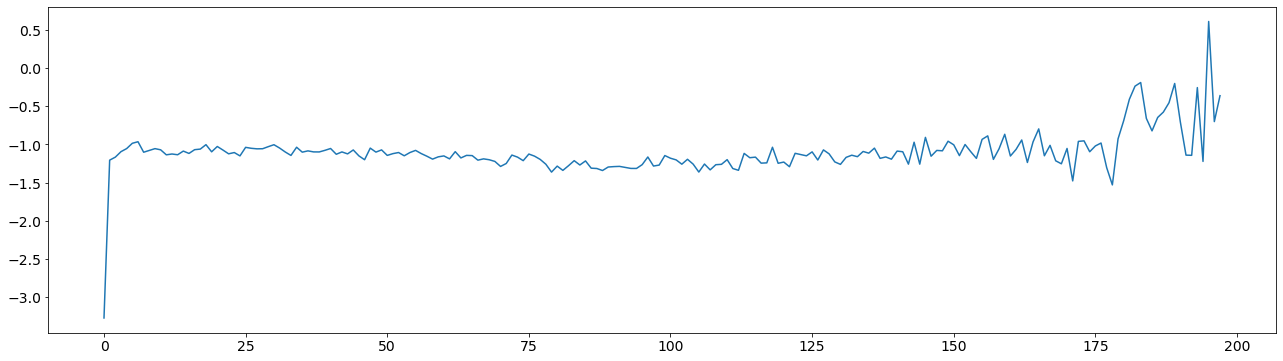

In [ ]:
_ = pd.Series(eval_treino).plot()

Para a série sem a decomposição:

In [ ]:
le_avg_aju, eval_aju = lyapunov_exponent(serie_aracaju.tavg[-365:].values, .1)
le_avg_aju

389.4878023210781

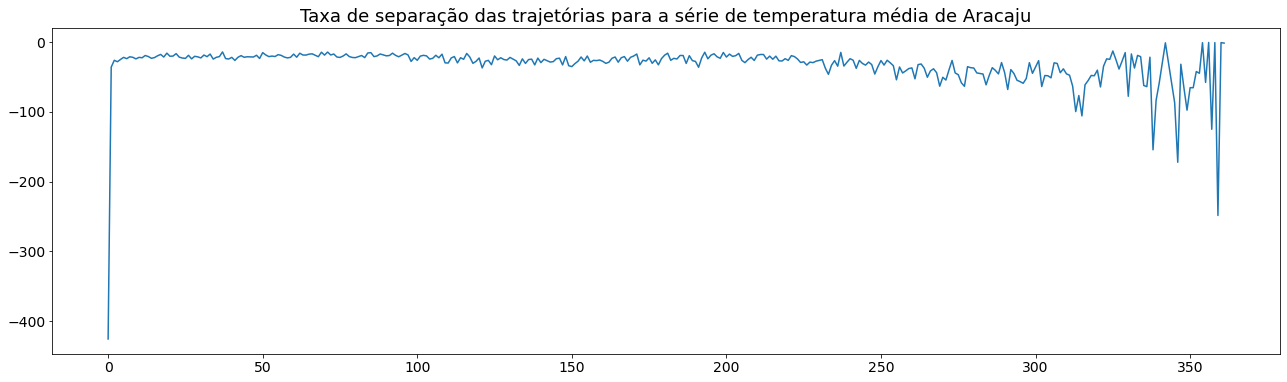

In [ ]:
_ = pd.Series(eval_aju).plot(title="Taxa de separação das trajetórias para a série de temperatura média de Aracaju")

### Encontrando o limite do horizonte

In [ ]:
mae = metrics.mean_absolute_error(treino,modelo_autoarima.fittedvalues)
H = -np.log(mae)/le_treino
H

2.237415642905445

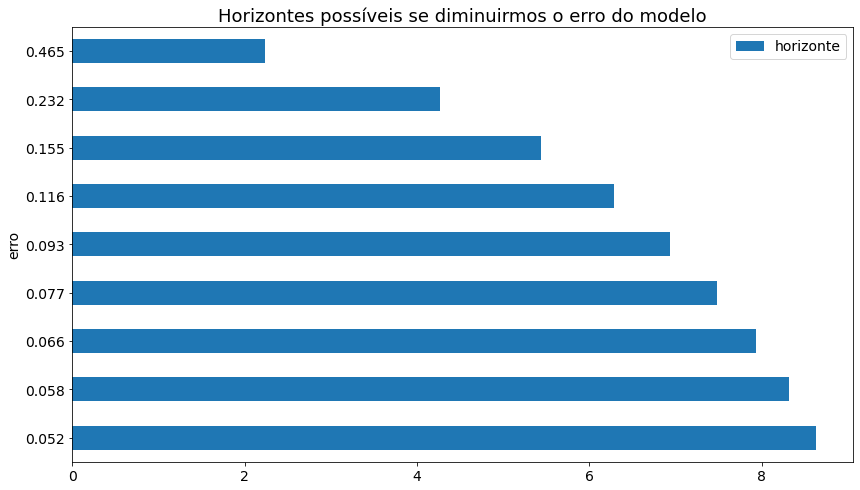

In [ ]:
Hs = pd.DataFrame([np.round(mae/i,3)  for i in range(1,10)], columns=["erro"])
Hs["horizonte"] = Hs.erro.apply(lambda x : -np.log(x)/le_treino)
_ = Hs.sort_values(by="erro").plot(kind="barh", y="horizonte", x="erro", figsize=(14,8),
            title="Horizontes possíveis se diminuirmos o erro do modelo")

### Visualizando os erros do horizonte

In [ ]:
resultado_h = predicao_por_rolagem_h(treino.iloc[-365:], teste, ordem, ts=30)

  0%|          | 0/876 [00:00<?, ?it/s]

In [ ]:
metricas = pd.DataFrame()
metricas["mae"] = pd.Series([metrics.mean_absolute_error(teste, resultado_h[i]) for i in range(1,resultado_h.shape[1])])
metricas["r_quadrado"] = pd.Series([metrics.r2_score(teste, resultado_h[i]) for i in range(1,resultado_h.shape[1])])
metricas["MedAE"] = pd.Series([metrics.median_absolute_error(teste, resultado_h[i]) for i in range(1,resultado_h.shape[1])])
metricas["MSE"] = pd.Series([metrics.mean_squared_error(teste, resultado_h[i]) for i in range(1,resultado_h.shape[1])])
metricas["MAPE"] = pd.Series([mape(teste.values, resultado_h[i]) for i in range(1,resultado_h.shape[1])])

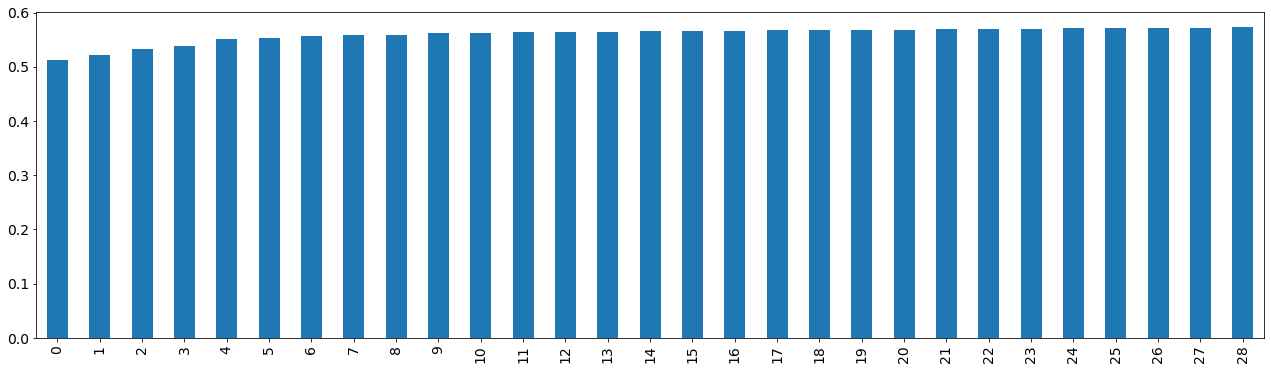

In [ ]:
_ = metricas.mae.plot(kind="bar")

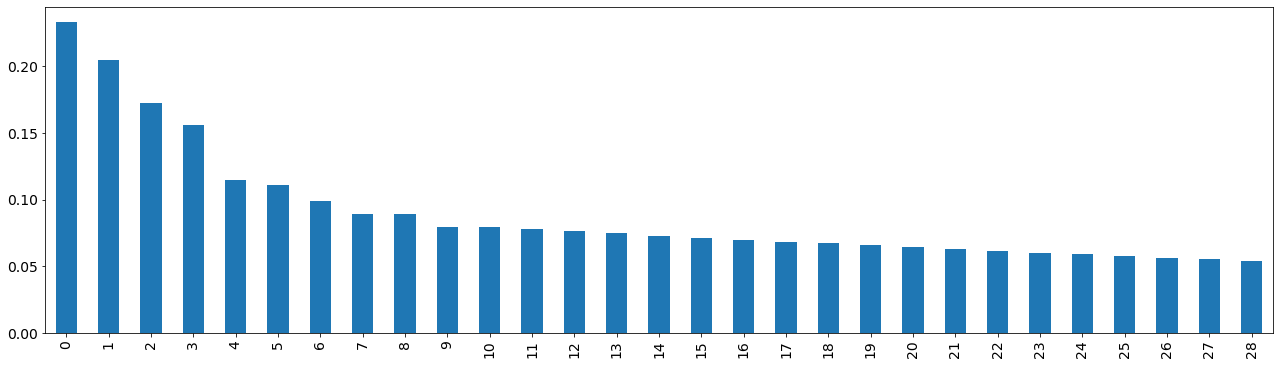

In [ ]:
_ = metricas.r_quadrado.plot(kind="bar")

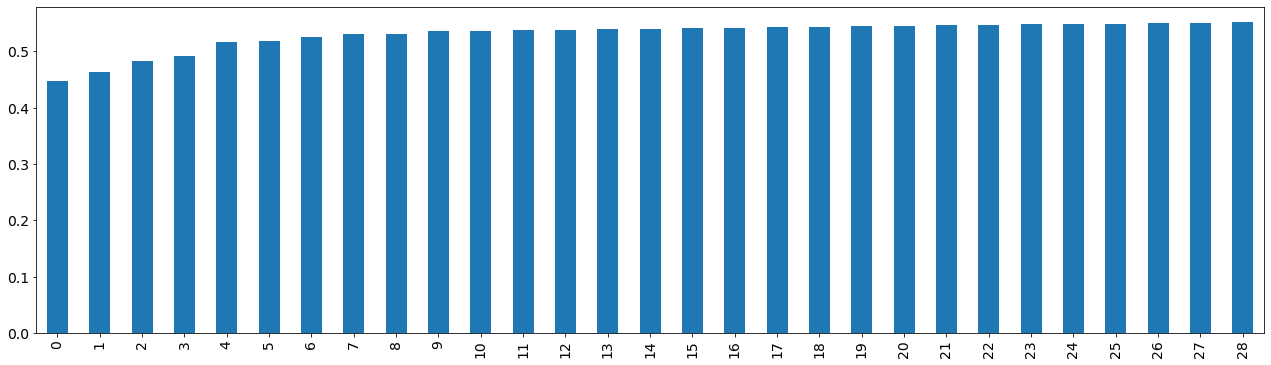

In [ ]:
_ = metricas.MSE.plot(kind="bar")

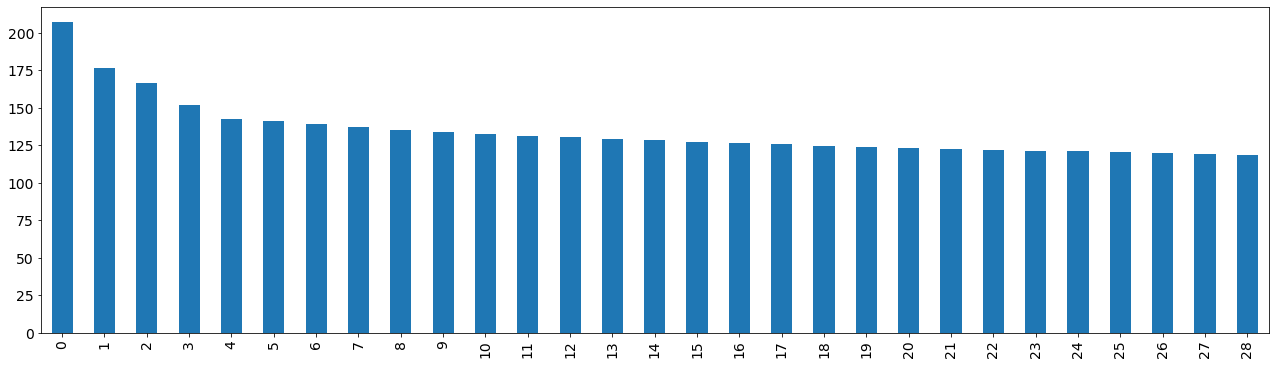

In [ ]:
_ = metricas.MAPE.plot(kind="bar")

## Intervalo de confiânça

### O método clássico

A ideia é usar os resíduos de nosso modelo para estimar quanto desvio podemos esperar de novas previsões.

O algoritmo funciona da seguinte forma:
- Treine o modelo no conjunto de treinamento
- Calcule os resíduos das previsões no conjunto de treinamento
- Selecione o quantil (1 - alfa) da distribuição dos resíduos
- Some e subtraia cada previsão deste quantil para obter os limites do intervalo de confiança

In [ ]:
def generate_results_dataset(preds, ci):
    df = pd.DataFrame()
    df['Predição'] = preds
    if ci >= 0:
        df['limite superior'] = preds + ci
        df['limite inferior'] = preds - ci
    else:
        df['limite superior'] = preds - ci
        df['limite inferior'] = preds + ci
        
    return df

In [ ]:
predicao_arima = modelo_autoarima.fittedvalues

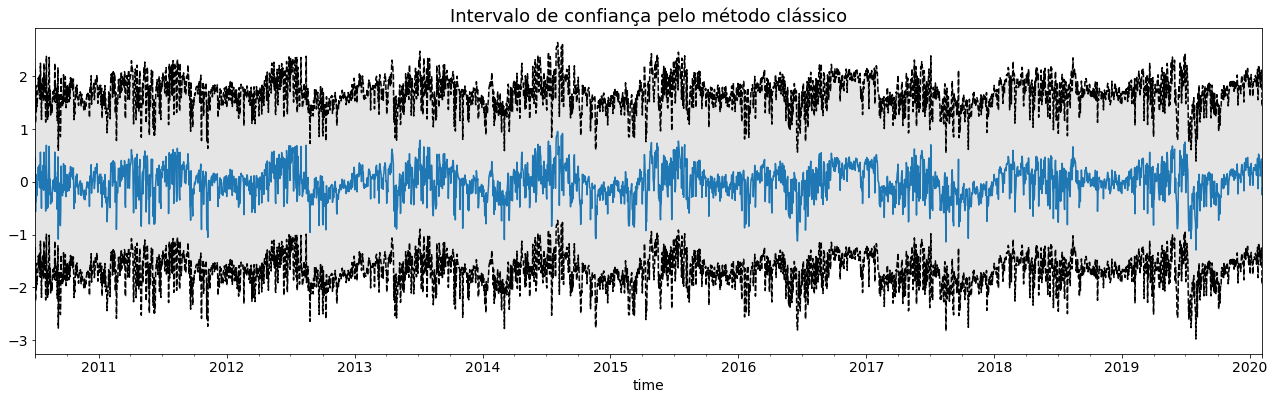

In [ ]:
scale = 1.96
mae = metrics.mean_absolute_error(predicao_arima, treino)
deviation = np.std(treino - predicao_arima)
ci = (mae + scale * deviation)

pred_ci = generate_results_dataset(predicao_arima, ci)
ax = pred_ci['Predição'].plot(title="Intervalo de confiança pelo método clássico")
pred_ci['limite superior'].plot(ax=ax,style="k--")
pred_ci['limite inferior'].plot(ax=ax,style="k--")
_ = ax.fill_between(
            x=pred_ci.index,
            y1=pred_ci['limite superior'],
            y2=pred_ci['limite inferior'],
            alpha=0.2,
            color="grey",
        )

No entanto, essa solução ingênua é problemática porque nosso modelo pode superajustar e mesmo que não, na maioria das vezes o erro no conjunto de treinamento será menor que o erro no conjunto de teste, afinal esses pontos são conhecidos pelo modelo.

Isso pode levar a intervalos de confiança excessivamente otimistas.

### O método de Jackknife

O método Jackknife tenta superar o resultado excessivamente otimista do método clássico. Para fazer isso, ele não usa os resíduos do conjunto de treinamento, em vez disso, usa os resíduos das previsões leave-one-out.

In [ ]:
alpha = 0.05
ordem = result_df["(p, d, q)"].iloc[0]
ts = 1

In [ ]:
history = treino.iloc[-365:].copy()
model = sm.tsa.arima.ARIMA(history, order= ordem).fit()

estimators = []
predictions = []
results = {}
yhat = model.forecast()[0]

predictions.append(yhat)
history.loc[teste.index[0]] = teste[0]
for i in tqdm(range(1, 365)):
    model = sm.tsa.arima.ARIMA(history, order= ordem).fit()
    yhat = model.forecast(steps=ts)[0]
    predictions.append(yhat)
    history.loc[teste.index[i]] = teste[i]
    estimators.append(model)

predictions = pd.Series(predictions, index=teste[:365].index)
res = teste - predictions
ci = np.quantile(res, 1 - alpha)

  0%|          | 0/364 [00:00<?, ?it/s]

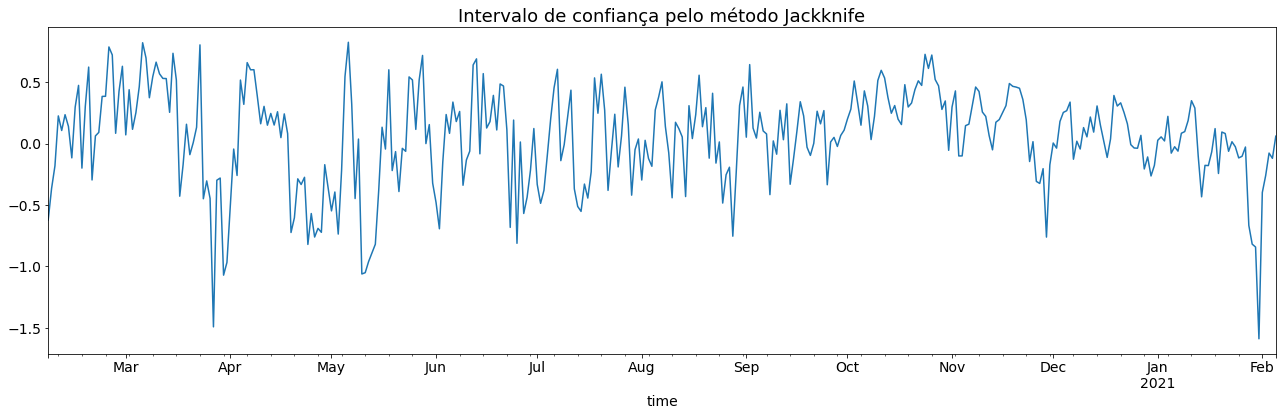

In [ ]:
df = generate_results_dataset(predictions, ci)
ax = df['Predição'].plot(title="Intervalo de confiança pelo método Jackknife")
df['limite superior'].plot(ax=ax,style="k--")
df['limite inferior'].plot(ax=ax,style="k--")
_ = ax.fill_between(
            x=df.index,
            y1=df['limite superior'],
            y2=df['limite inferior'],
            alpha=0.2,
            color="grey",
        )

Esse método funciona melhor que o clássico, porém ainda apresenta alguns problemas:

- O procedimento leave-one-out é altamente dispendioso e pode ser inviável em muitas aplicações
- Quando temos uma regressão com o número de dimensões se aproximando do número de instâncias, esse método perde abrangência.

### O método de Jackknife+

O método Jackknife+ tenta resolver a perda de cobertura do método Jackknife que ocorre devido ao modelo ajustado em todo o conjunto de treinamento.

Para fazer isso, ele usará todos os modelos treinados leave-one-out para gerar a previsão. Com isso, o modelo que faz as previsões para o ponto médio do intervalo será comparável aos resíduos.

In [ ]:
y_pred_multi = np.column_stack([e.predict(start=teste.index[0], end=teste.index[-1]) for e in estimators])

In [ ]:
ci = np.quantile(res, 1 - alpha)
top = []
bottom = []
for i in range(y_pred_multi.shape[0]):
    if ci > 0:
        top.append(np.quantile(y_pred_multi[i] + ci, 1 - alpha))
        bottom.append(np.quantile(y_pred_multi[i] - ci, 1 - alpha))
    else:
        top.append(np.quantile(y_pred_multi[i] - ci, 1 - alpha))
        bottom.append(np.quantile(y_pred_multi[i] + ci, 1 - alpha))

In [ ]:
preds = np.median(y_pred_multi, axis=1)
df = pd.DataFrame()
df['Predição'] = preds
df['limite superior'] = top
df['limite inferior'] = bottom

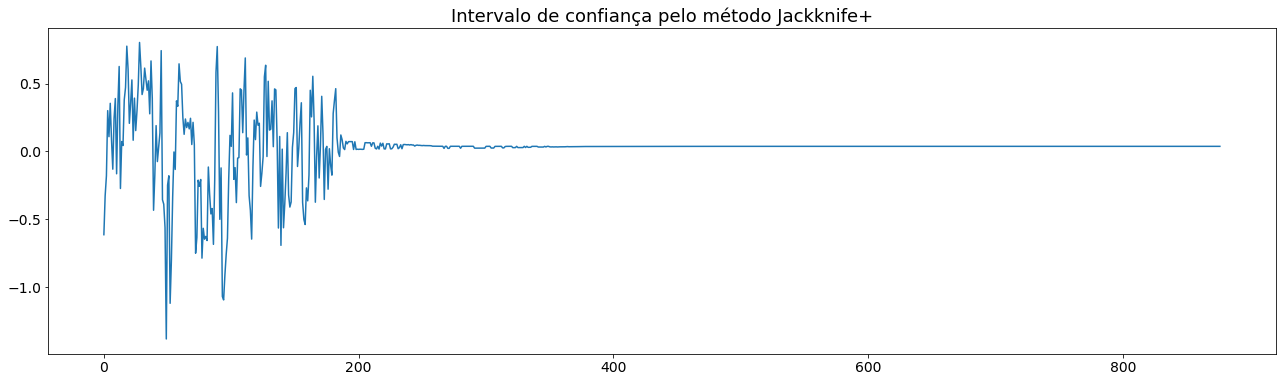

In [ ]:
ax = df['Predição'].plot(title="Intervalo de confiança pelo método Jackknife+")
df['limite superior'].plot(ax=ax,style="k--")
df['limite inferior'].plot(ax=ax,style="k--")
_ = ax.fill_between(
            x=df.index,
            y1=df['limite superior'],
            y2=df['limite inferior'],
            alpha=0.2,
            color="grey",
        )

Agora, este método não resolve o problema do tempo gasto para gerar o intervalo de confiança. Ele reduz apenas um procedimento de ajuste, mas adiciona a sobrecarga de previsão com cada modelo.

### O método CV+

O método CV+ tenta resolver o problema do tempo necessário para gerar os intervalos. É exatamente o mesmo que o Jackknife+, no entanto, ele usa uma validação cruzada K-Fold em vez de deixar um de fora.

In [ ]:
split_aju = int(len(serie_aracaju.tavg) * 80 / 100) #encontrando o ponto de separação de 80% para treino e 20% para teste
treino_aju, teste_aju = serie_aracaju.tavg[:split_aju], serie_aracaju.tavg[split_aju:]

In [ ]:
tscv = TimeSeriesSplit(n_splits=5, gap=5, test_size=365)
res = []
estimators = []

for train_index, test_index in tqdm(tscv.split(treino_aju), total=tscv.get_n_splits(), desc="Time Series Split"):
  treino_, teste_ = treino_aju[train_index], treino_aju[test_index]
  
  holtwinters_aju = sm.tsa.ExponentialSmoothing(treino_, initialization_method='estimated', damped_trend=True,
                                      trend="add", seasonal="add", seasonal_periods=365).fit(
                                      optimized=True, method="TNC")
  pred_arima = holtwinters_aju.predict(start=teste_.index[0], end=teste_.index[-1])

  estimators.append(holtwinters_aju)
  res.extend(list(teste_ - pred_arima))

Time Series Split:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
y_pred_multi = np.column_stack([e.predict(start=teste_aju.index[0], end=teste.index[-1]) for e in estimators])

In [ ]:
ci = np.quantile(res, 1 - alpha)
top = []
bottom = []
for i in range(y_pred_multi.shape[0]):
    if ci > 0:
        top.append(np.quantile(y_pred_multi[i] + ci, 1 - alpha))
        bottom.append(np.quantile(y_pred_multi[i] - ci, 1 - alpha))
    else:
        top.append(np.quantile(y_pred_multi[i] - ci, 1 - alpha))
        bottom.append(np.quantile(y_pred_multi[i] + ci, 1 - alpha))

In [ ]:
preds = np.median(y_pred_multi, axis=1)
df = pd.DataFrame()
df['Predição'] = preds
df['limite superior'] = top
df['limite inferior'] = bottom

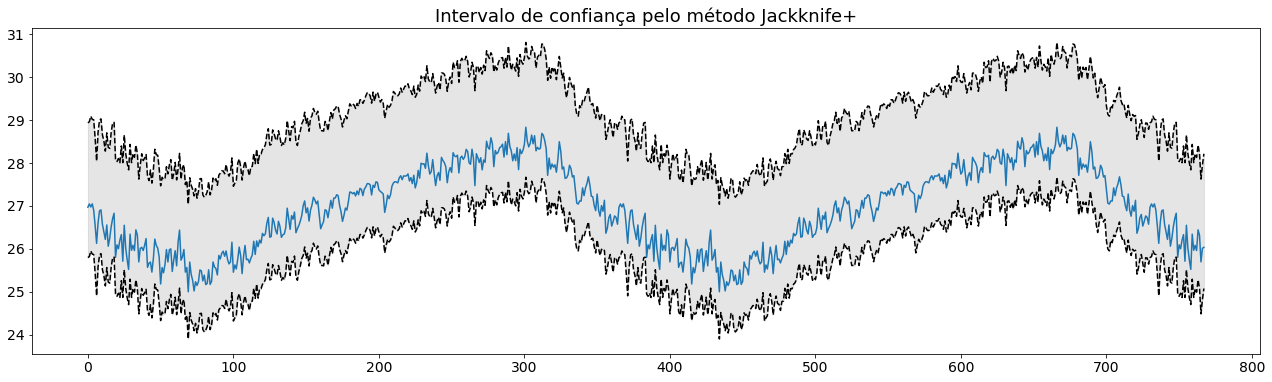

In [ ]:
ax = df['Predição'].plot(title="Intervalo de confiança pelo método Jackknife+")
df['limite superior'].plot(ax=ax,style="k--")
df['limite inferior'].plot(ax=ax,style="k--")
_ = ax.fill_between(
            x=df.index,
            y1=df['limite superior'],
            y2=df['limite inferior'],
            alpha=0.2,
            color="grey",
        )

## Exercício

1. Realize a análise dos resíduos da safra de teste, depois de aplicar a predição utilizando o método de rolagem.
2. Cálculo o horizonte de predição do modelo a partir do erro absoluto médio da safra de teste.
3. Ajuste um modelo SARIMA para a série de temperatura de sua cidade e cálcule o intervalo de confiança pra a previsão da safra de teste a partir do método CV+.

## Referências
- https://towardsdatascience.com/4-things-to-do-when-applying-cross-validation-with-time-series-c6a5674ebf3a
- https://machinelearningmastery.com/probabilistic-model-selection-measures/
- https://mlcourse.ai/book/topic09/topic9_part1_time_series_python.html#triple-exponential-smoothing-a-k-a-holt-winters
- https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html
- https://towardsdatascience.com/generating-confidence-intervals-for-regression-models-2dd60026fbce
